In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
%matplotlib inline
from matplotlib import pyplot as plt
from dataclasses import dataclass
import numpy as np

In [2]:
# setup for GPU usage, with cuda ofc.
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    print('Training on CPU!')

In [3]:
# I try to separate the hyperparameters here, this is usefull when I move to production
@dataclass
class hyperparams:
    # General
    epochs: int = 20
    batch_size: int = 32
    
    # Optimizer
    learning_rate: float = 0.01
    momentum: float = 0.5

In [4]:
# Construct a labelmap for the EMNIST balanced set, so I have a reference of each class label to a number or letter based from the paper
label_map = {
    # not PEP8 formatted, but readable
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'd', 39: 'e',
    40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't',
}

In [5]:
# First, I download the dataset and make generators for it, I will use the torchvision API to load the EMNIST dataset as it comes with dataset generators included.

# Declare a transformer for the generator, transformations on the data can be done here, implemented compose to make adding transformation later on more easyer.
transformer = transforms.Compose([
    # First, fix the import rotate and flip all images to readable format
    lambda img: transforms.functional.rotate(img, -90),
    lambda img: transforms.functional.hflip(img),
    
    # Do some preprocessing here:
    # Pad the images to a larger size to get the maximum from the highest level feature detectors conf. LeCun
    transforms.Pad(2),
    
    # Normalize the data:
    
    transforms.ToTensor(),])

# Define the train loader
train_loader = DataLoader(
    datasets.EMNIST('data/',
                    split='balanced',
                    train=True,
                    download=True,
                    transform=transformer),
    batch_size=hyperparams.batch_size,
    shuffle=True)

# Define the test loader
test_loader = DataLoader(
    datasets.EMNIST('data/',
                    split='balanced',
                    train=False,
                    download=True,
                    transform=transformer),
    batch_size=hyperparams.batch_size,
    shuffle=True)

In [6]:
# Make preparations to inspect the data
# By using an enumerator, it is possible to retrieve one batch per call made to the enumerator.
train_enumerator = enumerate(train_loader)

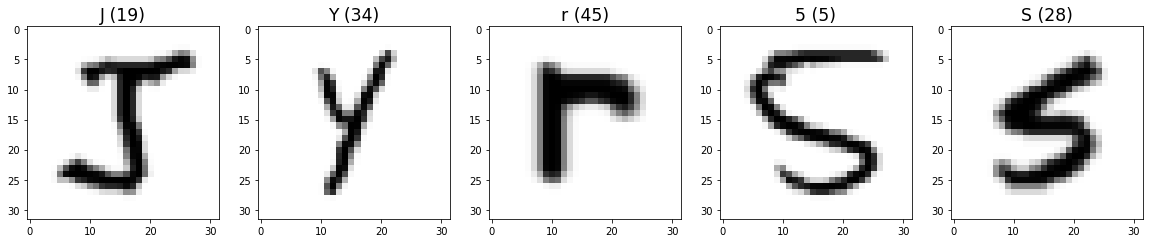

In [7]:
view_batch, (view_batch_images, view_batch_labels) = next(train_enumerator)

# Now, plot the first x images and their labels from the batch for manual evaluation
plt.figure(figsize=(20,5))
image_count = 5

for i, s in enumerate(range(image_count)):
    s = s+1
    p = plt.subplot(1, image_count, s)
    p.imshow(view_batch_images[i][0], cmap='binary')
    label = view_batch_labels[i]
    resolved = label_map[int(label)]
    p.set_title('{} ({})'.format(resolved, label), fontsize='xx-large')
plt.show()

In [8]:
class LeNet5(nn.Module):

    def __init__(self, n_features):
        super(LeNet5, self).__init__()

        # Convolutional feature extractor
        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.c3 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.c5 = nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5)

        # Feed foreward network
        self.f6 = nn.Linear(in_features=120, out_features=84)
        # Customizable output features, allows us to work with different sets without refedining the model
        self.f7 = nn.Linear(in_features=84, out_features=n_features)

        # Define activation function and pooling layers, which are the same troughout the entire network
        self.tanh = nn.Tanh()
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        # RBF not available in pytorch, replacing with softmax which is good for classification
        self.softmax = nn.Softmax(dim=-1)


    def forward(self, x):
        x = self.c1(x)
        x = self.tanh(x)
        x = self.pool(x) #s2

        x = self.c3(x)
        x = self.tanh(x)
        x = self.pool(x) #s4

        x = self.c5(x)
        x = self.tanh(x)

        x = torch.flatten(x, 1)

        x = self.f6(x)
        x = self.tanh(x)

        x = self.f7(x)
        x = self.softmax(x)
        return x


model = LeNet5(47)

# convert the NN to cuda tensors
if torch.cuda.is_available():
    model.to(device)

In [9]:
# lets use the CrossEntropy as loss function
loss_metric = nn.CrossEntropyLoss()

# and the SGD as optimizer for now
optimizer = optim.SGD(model.parameters(), lr=hyperparams.learning_rate , momentum=hyperparams.momentum)

In [10]:
# a list for the metrics
epoch_train_losses = []
epoch_val_losses = []

# training-loop
for epoch in range(hyperparams.epochs):
    
    # go over all the batches
    for batch in train_loader:
        # first, retrieve our data for this batch and send it to the GPU
        images = batch[0].to(device)
        labels = batch[1].to(device)
        
        # set the parameter gradients to zero
        optimizer.zero_grad()
        
        # Make predictions based on the training set
        outputs = model(images)
        
        # compute the loss based on model output and real labels
        loss = loss_metric(outputs, labels)
        
        # backpropagation
        loss.backward()
        
        # Optimize parameters
        optimizer.step()
        
    # === loss stats every epoch ===
    # put network in eval mode
    model.eval()
    for val_data in test_loader:
        images = val_data[0].to(device)
        labels = val_data[1].to(device)

        output = model(images)
        val_loss = loss_metric(output, labels)

    epoch_train_losses.append(loss.item())
    epoch_val_losses.append(val_loss.item())

    # back to training
    model.train()

    # stolen from exercises
    print("Epoch: {}/{}...".format(epoch+1, hyperparams.epochs),
          "Loss: {:.6f}...".format(loss.item()),
          "Val Loss: {:.6f}".format(val_loss.item()))

Epoch: 1/20... Loss: 0.698586... Val Loss: 0.738245
Epoch: 2/20... Loss: 0.323370... Val Loss: 1.380418
Epoch: 3/20... Loss: 0.504184... Val Loss: 0.895097
Epoch: 4/20... Loss: 0.242852... Val Loss: 0.149778
Epoch: 5/20... Loss: 0.352154... Val Loss: 0.321880
Epoch: 6/20... Loss: 0.244178... Val Loss: 0.129598
Epoch: 7/20... Loss: 0.347517... Val Loss: 0.144559
Epoch: 8/20... Loss: 0.181965... Val Loss: 0.222567
Epoch: 9/20... Loss: 0.188668... Val Loss: 0.664914
Epoch: 10/20... Loss: 0.251545... Val Loss: 0.200526
Epoch: 11/20... Loss: 0.215426... Val Loss: 0.312994
Epoch: 12/20... Loss: 0.237094... Val Loss: 0.623283
Epoch: 13/20... Loss: 0.185781... Val Loss: 0.092453
Epoch: 14/20... Loss: 0.195388... Val Loss: 0.076523
Epoch: 15/20... Loss: 0.192808... Val Loss: 0.320348
Epoch: 16/20... Loss: 0.246522... Val Loss: 0.188247
Epoch: 17/20... Loss: 0.377428... Val Loss: 0.233341
Epoch: 18/20... Loss: 0.088049... Val Loss: 0.445100
Epoch: 19/20... Loss: 0.171122... Val Loss: 0.253716
Ep

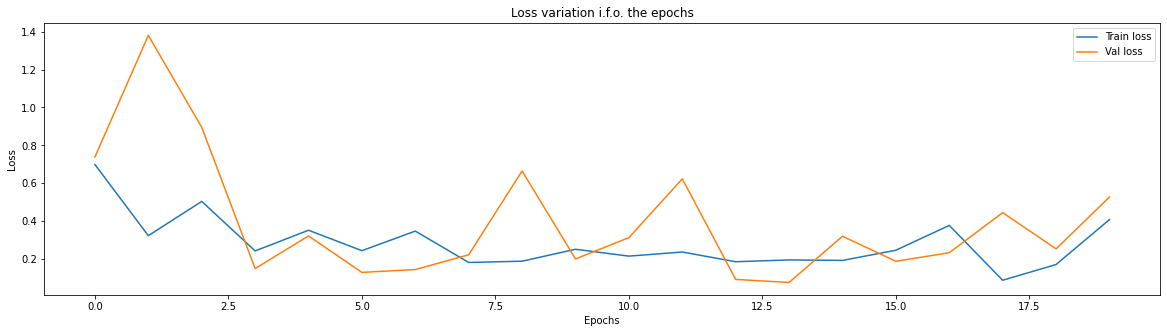

In [11]:
plt.figure(figsize=(20,5))

ax1 = plt.plot(epoch_train_losses, label='Train loss')
ax2 = plt.plot(epoch_val_losses, label='Val loss')

plt.title('Loss variation i.f.o. the epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [12]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running images through the network
        outputs = model(inputs)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 87 %


In [13]:
#prepare to count predictions for each class
correct_pred = {label_map[key]: 0 for key in label_map}
total_pred = {label_map[key]: 0 for key in label_map}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = model(inputs)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[label_map[int(label)]] += 1
            total_pred[label_map[int(label)]] += 1


# print accuracy for each class
accuracies = []
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))
    accuracies.append(accuracy)

Accuracy for class 0     is: 84.2 %
Accuracy for class 1     is: 87.2 %
Accuracy for class 2     is: 87.2 %
Accuracy for class 3     is: 98.0 %
Accuracy for class 4     is: 92.8 %
Accuracy for class 5     is: 92.0 %
Accuracy for class 6     is: 92.5 %
Accuracy for class 7     is: 97.2 %
Accuracy for class 8     is: 90.8 %
Accuracy for class 9     is: 72.5 %
Accuracy for class A     is: 92.8 %
Accuracy for class B     is: 92.0 %
Accuracy for class C     is: 96.8 %
Accuracy for class D     is: 86.5 %
Accuracy for class E     is: 97.8 %
Accuracy for class F     is: 55.0 %
Accuracy for class G     is: 93.0 %
Accuracy for class H     is: 95.0 %
Accuracy for class I     is: 52.8 %
Accuracy for class J     is: 92.5 %
Accuracy for class K     is: 95.5 %
Accuracy for class L     is: 37.0 %
Accuracy for class M     is: 95.0 %
Accuracy for class N     is: 94.8 %
Accuracy for class O     is: 53.2 %
Accuracy for class P     is: 92.5 %
Accuracy for class Q     is: 91.5 %
Accuracy for class R     is:

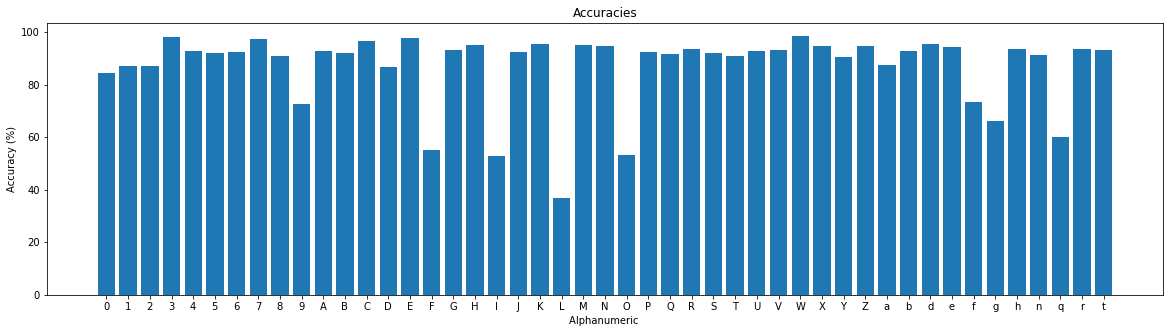

In [14]:
labels = list(label_map.values())

plt.figure(figsize=(20,5))
ax = plt.bar(labels, accuracies)
plt.title('Accuracies')
plt.xlabel('Alphanumeric ')
plt.ylabel('Accuracy (%)')

plt.show()